# Computing NPP from CMEMS 3D ML derived Chla and Bbp products

The idea is to compute Net Primary Production (NPP) using Chlorophyll-a (Chla) and backscatter at 700 nm (Bbp) data from the Copernicus Marine Environment Monitoring Service (CMEMS) 3D products, aggregating observation to a degree grid and matching with modis PAR data, averaged over a week to match CMEMS product temporal resolution. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from argopy import ArgoFloat


In [2]:
dat = xr.open_dataset("../Data/Raw/cmems_obs-mob_glo_bgc-chl-poc_my_0.25deg_P7D-m_multi-vars_39.88W-10.12W_58.12N-64.88N_0.00-200.00m_2015-01-07-2023-12-27.nc")

Open a float dataset and select relevent vars


In [3]:


WMO = 6904185 # Use any f

argo_ds = ArgoFloat(WMO).open_dataset("Sprof")

argo_filtered = argo_ds[['LATITUDE', 'LONGITUDE', 'JULD', 'CHLA_ADJUSTED', 'BBP700', 'PRES', 'TEMP', 'PSAL']]

In [4]:
max(argo_ds.JULD.values), min(argo_ds.JULD.values)

(np.datetime64('2024-02-22T09:01:00.000000000'),
 np.datetime64('2022-07-25T11:31:00.000000000'))

In [5]:
max(argo_ds.LONGITUDE.values), min(argo_ds.LONGITUDE.values)

(np.float64(-21.906956666666666), np.float64(-46.88777))

In [6]:
min(argo_ds.LATITUDE.values), max(argo_ds.LATITUDE.values)

(np.float64(58.067863333333335), np.float64(65.15927833333333))

Bin the data to a 5m resolution

In [7]:
bins = np.arange(0, 200, 5)

argo_binned = argo_filtered.argo.groupby_pressure_bins(bins, 'PRES',  select = 'median')
argo_binned["date"] = xr.DataArray(
    pd.to_datetime(argo_binned["JULD"].values),
    dims=("N_PROF",)
) #Making a date variable for clarity when matching with model data

In [8]:
# Swap the profile dimension to use the datetime coordinate and drop the old index
if "N_PROF" in argo_binned.dims:
    argo_binned = argo_binned.swap_dims({"N_PROF": "date"})
    if "N_PROF" in argo_binned.coords:
        argo_binned = argo_binned.drop_vars("N_PROF")

In [9]:
argo_binned = argo_binned.where(argo_binned['date'] < max(dat['time'].values), drop =True)

In [10]:
argo_binned

<xarray.Dataset> Size: 83kB
Dimensions:        (date: 104, N_LEVELS: 38)
Coordinates:
    STD_PRES_BINS  (N_LEVELS) int64 304B 0 5 10 15 20 25 ... 165 170 175 180 185
  * N_LEVELS       (N_LEVELS) int64 304B 0 1 2 3 4 5 6 ... 31 32 33 34 35 36 37
  * date           (date) datetime64[ns] 832B 2022-07-25T11:31:00 ... 2023-12...
Data variables:
    BBP700         (date, N_LEVELS) float32 16kB 0.004476 0.003843 ... 0.0005934
    CHLA_ADJUSTED  (date, N_LEVELS) float32 16kB 1.166 1.166 ... 0.0216 0.018
    JULD           (date) datetime64[ns] 832B 2022-07-25T11:31:00 ... 2023-12...
    LATITUDE       (date) float64 832B 58.07 58.3 58.41 ... 62.25 62.3 62.29
    LONGITUDE      (date) float64 832B -23.16 -23.09 -22.9 ... -40.59 -40.88
    PRES           (date, N_LEVELS) float32 16kB 1.0 7.4 12.25 ... 182.9 187.5
    PSAL           (date, N_LEVELS) float32 16kB 35.12 35.13 ... 34.96 34.96
    TEMP           (date, N_LEVELS) float32 16kB 12.69 12.69 ... 6.506 6.493
Attributes:
    title:                Argo float vertical profile
    institution:          BODC
    source:               Argo float
    history:              2025-10-10T01:32:52Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.19 (version 12.05.2025 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182
    Processing_history:   Sub-sampled and re-aligned on standard bins

In [11]:
model_time = dat["chl"].sel(
    time=argo_binned["date"],
    method="nearest"
)["time"]

argo_binned["CHLA_ML"] = dat["chl"].sel(
    longitude=argo_binned["LONGITUDE"],
    latitude=argo_binned["LATITUDE"],
    depth=argo_binned["STD_PRES_BINS"],
    time=model_time,
    method="nearest"
)


In [12]:
dat

<xarray.Dataset> Size: 832MB
Dimensions:    (time: 469, depth: 22, latitude: 28, longitude: 120)
Coordinates:
  * depth      (depth) int16 44B 0 5 10 15 20 25 30 ... 90 100 125 150 175 200
  * latitude   (latitude) float32 112B 58.12 58.38 58.62 ... 64.38 64.62 64.88
  * longitude  (longitude) float32 480B -39.88 -39.62 -39.38 ... -10.38 -10.12
  * time       (time) datetime64[ns] 4kB 2015-01-07 2015-01-14 ... 2023-12-27
Data variables:
    chl        (time, depth, latitude, longitude) float32 139MB ...
    bbp        (time, depth, latitude, longitude) float32 139MB ...
    poc        (time, depth, latitude, longitude) float32 139MB ...
    poc_error  (time, depth, latitude, longitude) float32 139MB ...
    bbp_error  (time, depth, latitude, longitude) float32 139MB ...
    PAR        (time, depth, latitude, longitude) float32 139MB ...
Attributes:
    Conventions:               CF-1.6
    contact:                   servicedesk.cmems@mercator-ocean.eu
    description:               CMEMS MULTIOBS 3D BGC weekly global product es...
    domain_name:               GLO
    institution:               LOV/IMEV/CNRS
    project:                   CMEMS - MULTIOBS Thematic Assembly Center
    project_url:               http://marine.copernicus.eu
    references:                Sauzede et al. 2016 (Journal of Geophysical Re...
    title:                     Global Ocean 3D Chlorophyll-a concentration, P...
    copernicusmarine_version:  2.3.0

In [13]:
argo_binned["CHLA_ML"] = dat["chl"].sel(
    longitude=argo_binned["LONGITUDE"], 
    latitude=argo_binned["LATITUDE"], 
    time=argo_binned["date"], 
    depth=argo_binned['STD_PRES_BINS'],
    method="nearest"
)

argo_binned["BBP700_ML"] = dat["bbp"].sel(
    longitude=argo_binned["LONGITUDE"], 
    latitude=argo_binned["LATITUDE"], 
    time=argo_binned["date"], 
    depth=argo_binned['STD_PRES_BINS'],
    method="nearest"
)

argo_binned["PAR"] = dat["PAR"].sel(
    longitude=argo_binned["LONGITUDE"], 
    latitude=argo_binned["LATITUDE"], 
    time=argo_binned["date"], 
    depth=argo_binned['STD_PRES_BINS'],
    method="nearest"
)


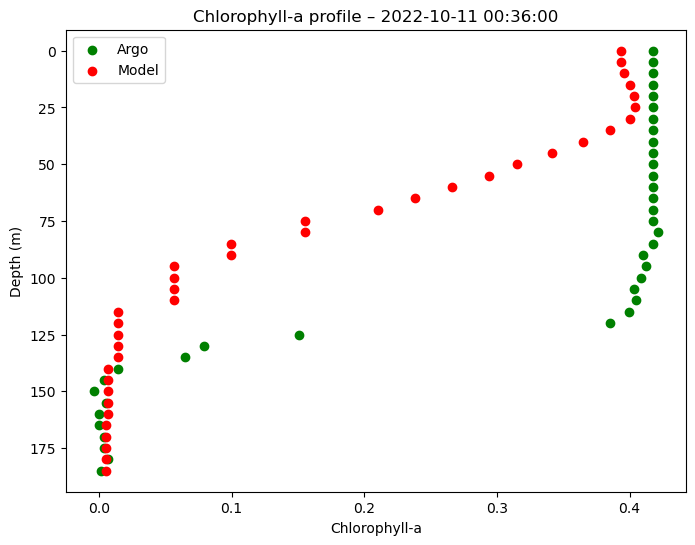

In [14]:
profile_to_check = 18
plot_prof = argo_binned.sel(date = argo_binned.date[profile_to_check])


fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    plot_prof["CHLA_ADJUSTED"],
    plot_prof["STD_PRES_BINS"],
    c="green",
    label="Argo"
)

ax.scatter(
    plot_prof["CHLA_ML"],
    plot_prof["STD_PRES_BINS"],
    c="red",
    label="Model"
)

ax.set_title(
    f"Chlorophyll-a profile – {pd.to_datetime(plot_prof.JULD.values)}"
)
ax.set_xlabel("Chlorophyll-a")
ax.set_ylabel("Depth (m)")
ax.invert_yaxis()
ax.legend()



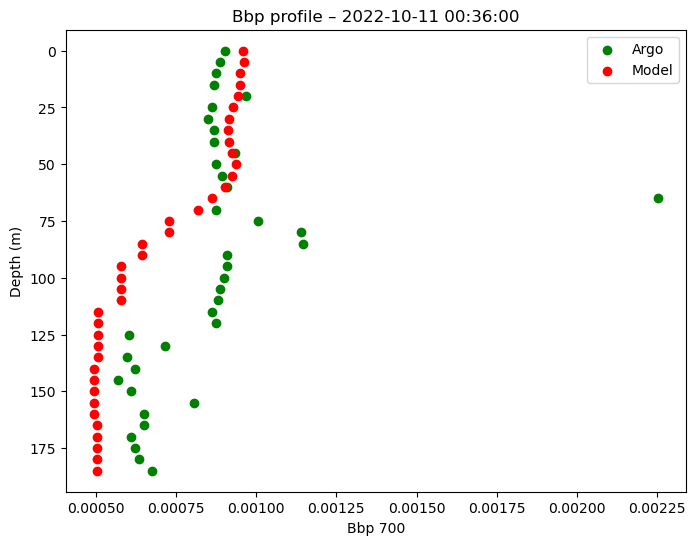

In [15]:
plot_prof = argo_binned.sel(date = argo_binned.date[profile_to_check])


fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    plot_prof["BBP700"],
    plot_prof["STD_PRES_BINS"],
    c="green",
    label="Argo"
)

ax.scatter(
    plot_prof["BBP700_ML"],
    plot_prof["STD_PRES_BINS"],
    c="red",
    label="Model"
)

ax.set_title(
    f"Bbp profile – {pd.to_datetime(plot_prof.JULD.values)}"
)
ax.set_xlabel("Bbp 700")
ax.set_ylabel("Depth (m)")
ax.invert_yaxis()
ax.legend()

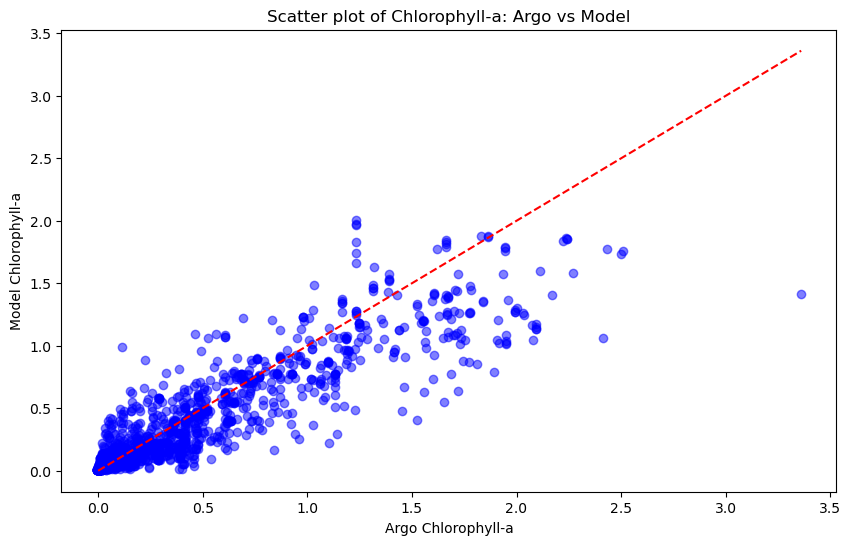

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(
    argo_binned["CHLA_ADJUSTED"],
    argo_binned["CHLA_ML"],
    c="blue",
    alpha=0.5
)
ax.set_title("Scatter plot of Chlorophyll-a: Argo vs Model")
ax.set_xlabel("Argo Chlorophyll-a")
ax.set_ylabel("Model Chlorophyll-a")
ax.plot([0, np.nanmax(argo_binned["CHLA_ADJUSTED"])], [0, np.nanmax(argo_binned["CHLA_ADJUSTED"])], 'r--')
plt.show()

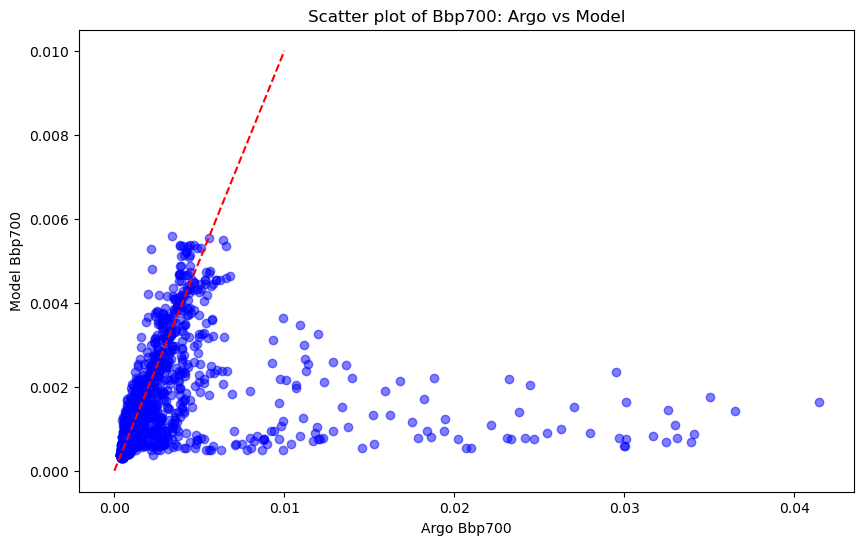

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(
    argo_binned["BBP700"],
    argo_binned["BBP700_ML"],
    c="blue",
    alpha=0.5
)
ax.set_title("Scatter plot of Bbp700: Argo vs Model")
ax.set_xlabel("Argo Bbp700")
ax.set_ylabel("Model Bbp700")
ax.plot([0, 0.01], [0, 0.01], 'r--')
plt.show()

In [18]:
from cbpm_py import cbpm_argo

In [19]:
#todo : broadcast chla and bbp value over continuous depth
# Match to modis par values 
#run npp

In [20]:
argo_binned

<xarray.Dataset> Size: 132kB
Dimensions:        (date: 104, N_LEVELS: 38)
Coordinates:
    STD_PRES_BINS  (N_LEVELS) int64 304B 0 5 10 15 20 25 ... 165 170 175 180 185
  * N_LEVELS       (N_LEVELS) int64 304B 0 1 2 3 4 5 6 ... 31 32 33 34 35 36 37
  * date           (date) datetime64[ns] 832B 2022-07-25T11:31:00 ... 2023-12...
    depth          (N_LEVELS) int16 76B 0 5 10 15 20 25 ... 175 175 175 175 175
    latitude       (date) float32 416B 58.12 58.38 58.38 ... 62.12 62.38 62.38
    longitude      (date) float32 416B -23.12 -23.12 -22.88 ... -39.88 -39.88
    time           (date) datetime64[ns] 832B 2022-07-27 ... 2023-12-27
Data variables:
    BBP700         (date, N_LEVELS) float32 16kB 0.004476 0.003843 ... 0.0005934
    CHLA_ADJUSTED  (date, N_LEVELS) float32 16kB 1.166 1.166 ... 0.0216 0.018
    JULD           (date) datetime64[ns] 832B 2022-07-25T11:31:00 ... 2023-12...
    LATITUDE       (date) float64 832B 58.07 58.3 58.41 ... 62.25 62.3 62.29
    LONGITUDE      (date) float64 832B -23.16 -23.09 -22.9 ... -40.59 -40.88
    PRES           (date, N_LEVELS) float32 16kB 1.0 7.4 12.25 ... 182.9 187.5
    PSAL           (date, N_LEVELS) float32 16kB 35.12 35.13 ... 34.96 34.96
    TEMP           (date, N_LEVELS) float32 16kB 12.69 12.69 ... 6.506 6.493
    CHLA_ML        (date, N_LEVELS) float32 16kB 1.34 1.345 1.356 ... nan nan
    BBP700_ML      (date, N_LEVELS) float32 16kB 0.004737 0.004864 ... nan nan
    PAR            (date, N_LEVELS) float32 16kB ...
Attributes:
    title:                Argo float vertical profile
    institution:          BODC
    source:               Argo float
    history:              2025-10-10T01:32:52Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.19 (version 12.05.2025 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182
    Processing_history:   Sub-sampled and re-aligned on standard bins

In [21]:
# Create a list to store the data
data_list = []

# Iterate through each date (profile)
for i, date_val in enumerate(argo_binned.date.values):
    profile_data = argo_binned.sel(date=date_val)
    
    # Iterate through each depth level
    for j, depth_val in enumerate(profile_data.STD_PRES_BINS.values):
        data_list.append({
            'profile_id': i + 1,
            'date': pd.to_datetime(date_val),
            'STD_PRES_BINS': depth_val,
            'latitude': float(profile_data.LATITUDE.values),
            'longitude': float(profile_data.LONGITUDE.values),
            'BBP700': float(profile_data.BBP700.values[j]),
            'CHLA_ADJUSTED': float(profile_data.CHLA_ADJUSTED.values[j]),
            'CHLA_ML': float(profile_data.CHLA_ML.values[j]),
            'BBP700_ML': float(profile_data.BBP700_ML.values[j]),
            'PAR': float(profile_data.PAR.values[j]),
            'temperature': float(profile_data.TEMP.values[j]),
            'salinity': float(profile_data.PSAL.values[j])
        })

# Create the DataFrame
df = pd.DataFrame(data_list)
df

,profile_id,date,STD_PRES_BINS,latitude,longitude,BBP700,CHLA_ADJUSTED,CHLA_ML,BBP700_ML,PAR,temperature,salinity
0,1,2022-07-25 11:31:00,0,58.067863,-23.156090,0.004476,1.1664,1.340331,0.004737,768.435242,12.690500,35.115299
1,1,2022-07-25 11:31:00,5,58.067863,-23.156090,0.003843,1.1664,1.344529,0.004864,328.269836,12.689000,35.129002
2,1,2022-07-25 11:31:00,10,58.067863,-23.156090,0.003915,1.1664,1.356301,0.004869,172.403152,12.685000,35.130661
3,1,2022-07-25 11:31:00,15,58.067863,-23.156090,0.004476,1.1664,1.371435,0.004864,94.168015,12.694201,35.133999
4,1,2022-07-25 11:31:00,20,58.067863,-23.156090,0.004014,1.1664,1.267691,0.004655,52.754692,12.698150,35.133999
...,...,...,...,...,...,...,...,...,...,...,...,...
3947,104,2023-12-25 11:43:00,165,62.293430,-40.884065,0.000567,0.0270,NaN,NaN,NaN,6.469429,34.953712
3948,104,2023-12-25 11:43:00,170,62.293430,-40.884065,0.003718,0.0252,NaN,NaN,NaN,6.483263,34.956421
3949,104,2023-12-25 11:43:00,175,62.293430,-40.884065,0.001793,0.0198,NaN,NaN,NaN,6.498658,34.959553
3950,104,2023-12-25 11:43:00,180,62.293430,-40.884065,0.000547,0.0216,NaN,NaN,NaN,6.506000,34.962002


In [40]:
import numpy as np

# Define the new depth range from 0 to 200 meters
new_depths = np.arange(0, 200, 1)  # 1m resolution

# Function to interpolate for each profile
def interpolate_profile(group):
    # Sort by STD_PRES_BINS
    group = group.sort_values('STD_PRES_BINS')
    
    # Create interpolation functions for each variable, skipping NaNs
    interp_funcs = {}
    for col in ['BBP700', 'CHLA_ADJUSTED', 'CHLA_ML', 'BBP700_ML', 'PAR', 'temperature', 'salinity']:
        if group[col].notna().any():
            # Use linear interpolation, fill NaNs with interpolated values
            interp_funcs[col] = np.interp(new_depths, group['STD_PRES_BINS'], group[col], left=np.nan, right=np.nan)
        else:
            interp_funcs[col] = np.full(len(new_depths), np.nan)
    
    # Create new dataframe for this profile
    new_df = pd.DataFrame({
        'profile_id': group['profile_id'].iloc[0],
        'date': group['date'].iloc[0],
        'PRES': new_depths,
        'latitude': group['latitude'].iloc[0],
        'longitude': group['longitude'].iloc[0],
        'BBP700': interp_funcs['BBP700'],
        'CHLA_ADJUSTED': interp_funcs['CHLA_ADJUSTED'],
        'CHLA_ML': interp_funcs['CHLA_ML'],
        'BBP700_ML': interp_funcs['BBP700_ML'],
        'PAR': interp_funcs['PAR'],
        'temperature': interp_funcs['temperature'],
        'salinity': interp_funcs['salinity']
    })
    
    return new_df

# Apply interpolation to each profile
interpolated_df = df.groupby('profile_id').apply(interpolate_profile).reset_index(drop=True)

# Display the new dataframe
interpolated_df

C:\Users\petit\AppData\Local\Temp\ipykernel_25976\4009706110.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interpolated_df = df.groupby('profile_id').apply(interpolate_profile).reset_index(drop=True)


,profile_id,date,PRES,latitude,longitude,BBP700,CHLA_ADJUSTED,CHLA_ML,BBP700_ML,PAR,temperature,salinity
0,1,2022-07-25 11:31:00,0,58.067863,-23.156090,0.004476,1.1664,1.340331,0.004737,768.435242,12.6905,35.115299
1,1,2022-07-25 11:31:00,1,58.067863,-23.156090,0.004349,1.1664,1.341171,0.004762,680.402161,12.6902,35.118040
2,1,2022-07-25 11:31:00,2,58.067863,-23.156090,0.004223,1.1664,1.342010,0.004788,592.369080,12.6899,35.120780
3,1,2022-07-25 11:31:00,3,58.067863,-23.156090,0.004096,1.1664,1.342850,0.004813,504.335999,12.6896,35.123521
4,1,2022-07-25 11:31:00,4,58.067863,-23.156090,0.003969,1.1664,1.343689,0.004838,416.302917,12.6893,35.126261
...,...,...,...,...,...,...,...,...,...,...,...,...
20795,104,2023-12-25 11:43:00,195,62.293430,-40.884065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20796,104,2023-12-25 11:43:00,196,62.293430,-40.884065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20797,104,2023-12-25 11:43:00,197,62.293430,-40.884065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20798,104,2023-12-25 11:43:00,198,62.293430,-40.884065,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\petit\AppData\Local\Temp\ipykernel_25976\1038584077.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


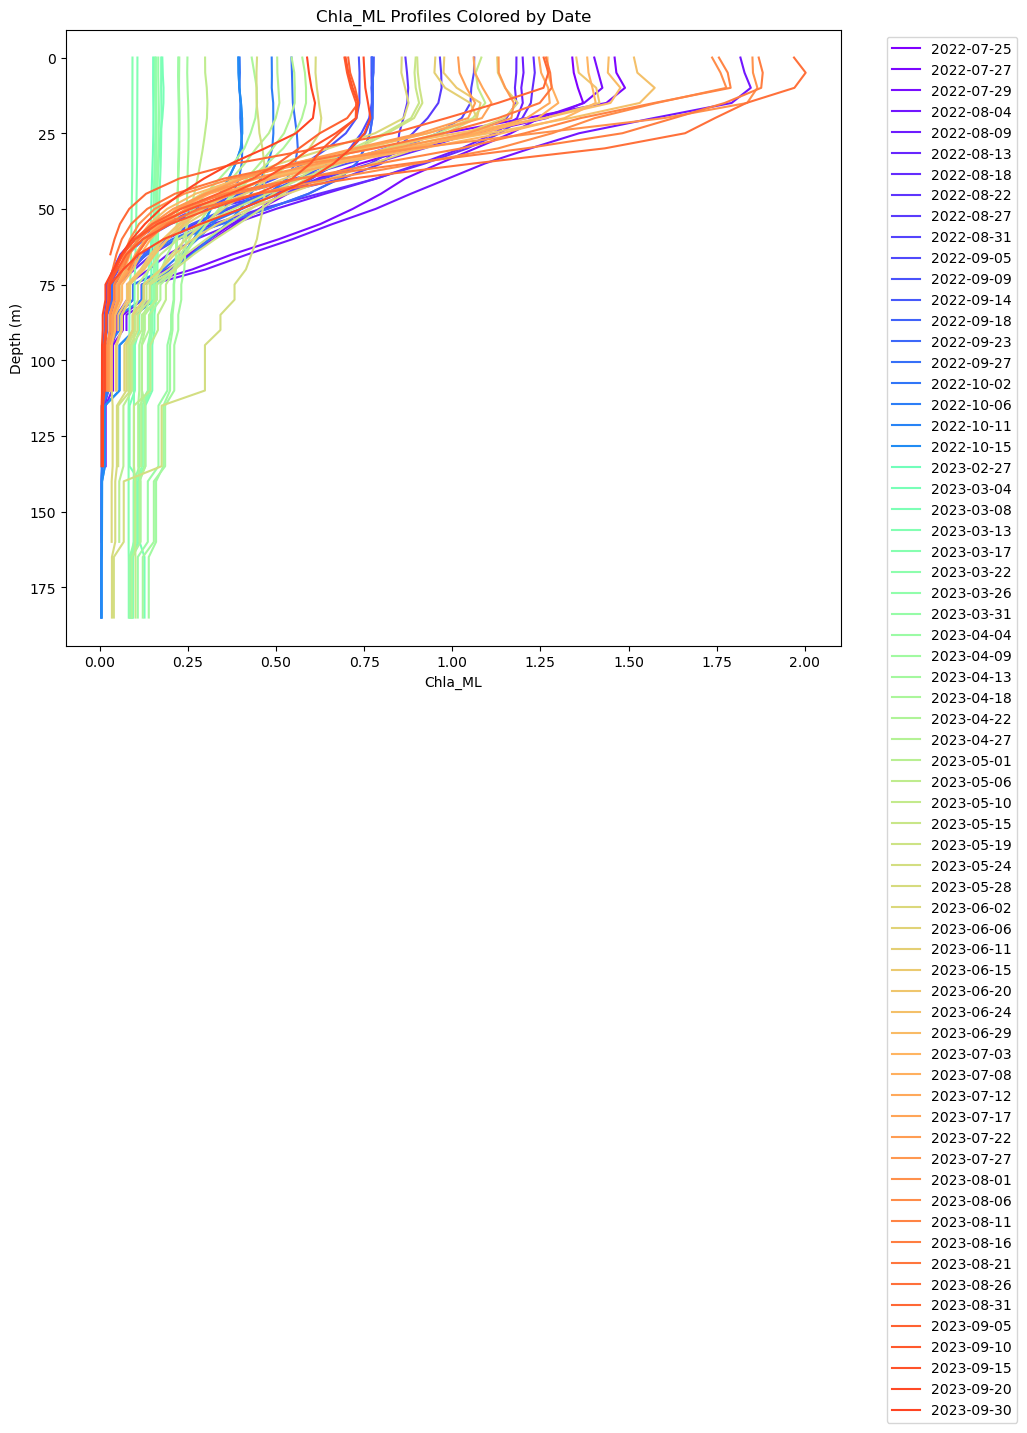

In [41]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get unique dates and sort them
unique_dates = sorted(interpolated_df['date'].unique())

# Create a rainbow colormap
cmap = plt.get_cmap('rainbow')
norm = mcolors.Normalize(vmin=0, vmax=len(unique_dates)-1)

fig, ax = plt.subplots(figsize=(10, 8))

for i, date in enumerate(unique_dates):
    profile_data = interpolated_df[interpolated_df['date'] == date].dropna(subset=['CHLA_ML'])
    if not profile_data.empty:
        ax.plot(profile_data['CHLA_ML'], profile_data['PRES'], color=cmap(norm(i)), label=str(date.date()))

ax.set_xlabel('Chla_ML')
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()
ax.set_title('Chla_ML Profiles Colored by Date')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\petit\AppData\Local\Temp\ipykernel_25976\2657097211.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


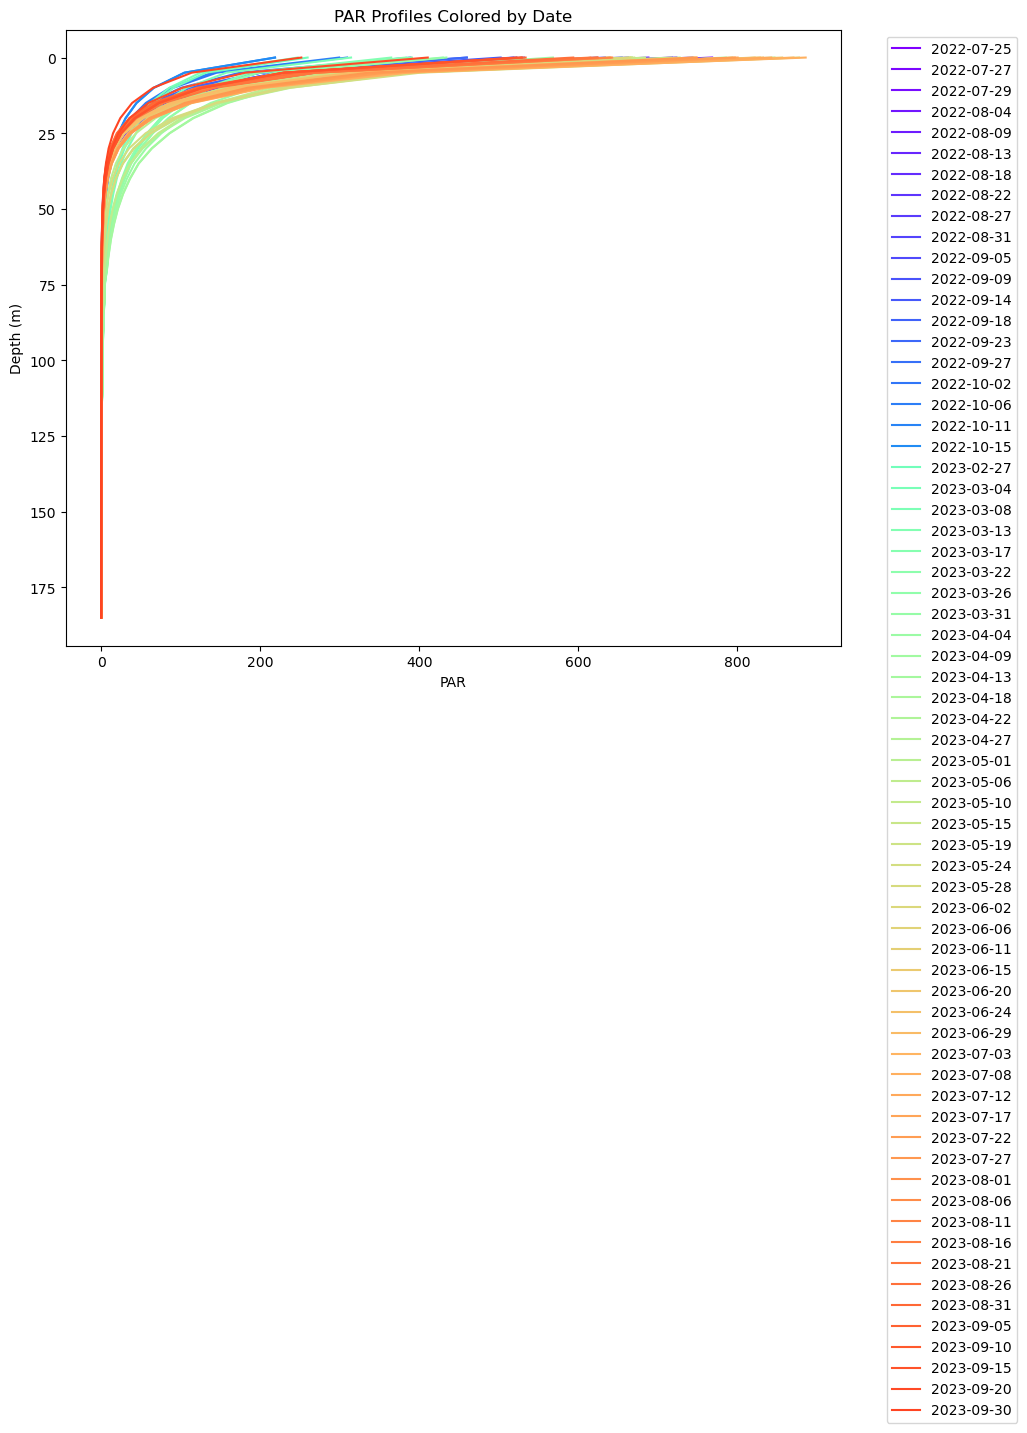

In [42]:
# Get unique dates and sort them
unique_dates = sorted(interpolated_df['date'].unique())

# Create a rainbow colormap
cmap = plt.get_cmap('rainbow')
norm = mcolors.Normalize(vmin=0, vmax=len(unique_dates)-1)

fig, ax = plt.subplots(figsize=(10, 8))

for i, date in enumerate(unique_dates):
    profile_data = interpolated_df[interpolated_df['date'] == date].dropna(subset=['PAR'])
    if not profile_data.empty:
        ax.plot(profile_data['PAR'], profile_data['PRES'], color=cmap(norm(i)), label=str(date.date()))

ax.set_xlabel('PAR')
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()
ax.set_title('PAR Profiles Colored by Date')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\petit\AppData\Local\Temp\ipykernel_25976\1294393981.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


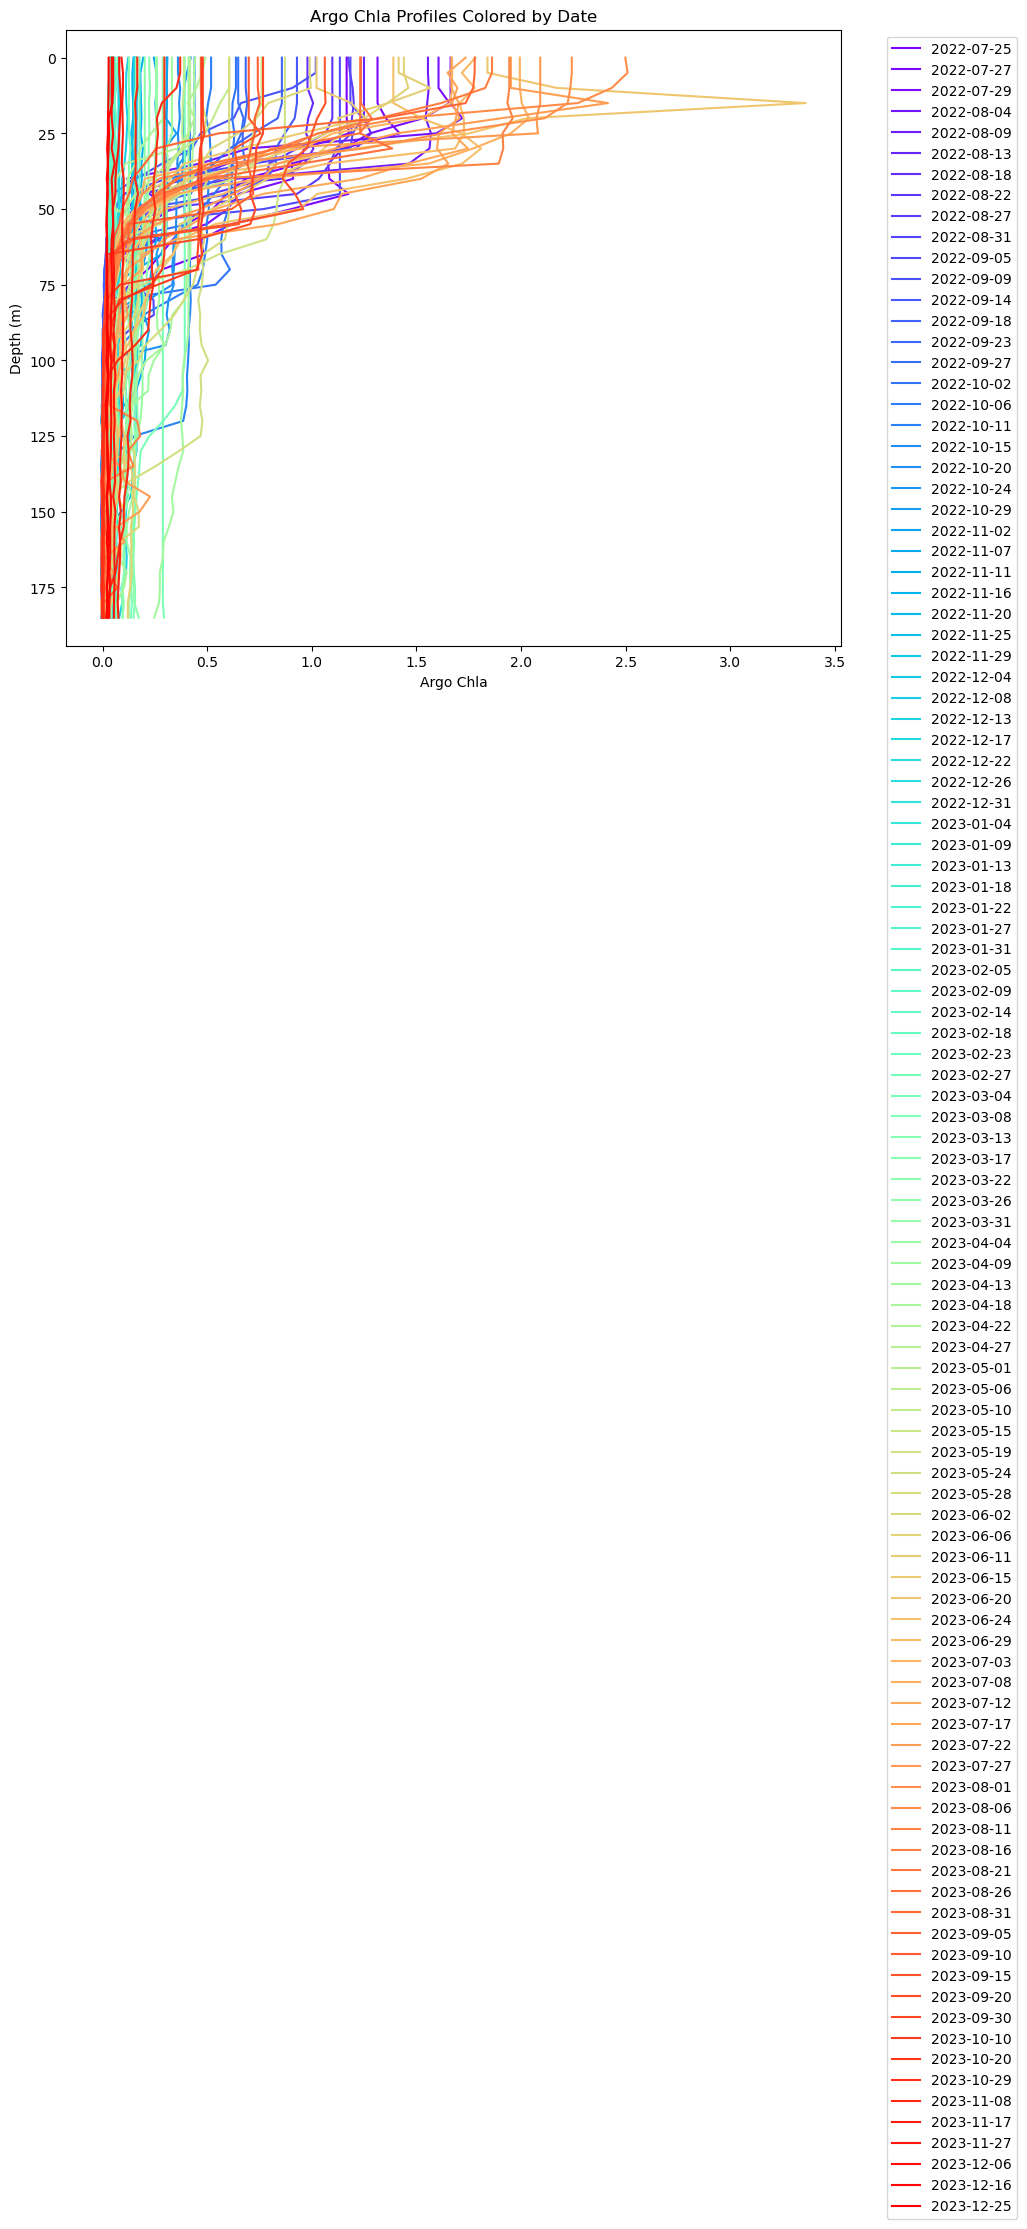

In [43]:
# Get unique dates and sort them
unique_dates = sorted(interpolated_df['date'].unique())

# Create a rainbow colormap
cmap = plt.get_cmap('rainbow')
norm = mcolors.Normalize(vmin=0, vmax=len(unique_dates)-1)

fig, ax = plt.subplots(figsize=(10, 8))

for i, date in enumerate(unique_dates):
    profile_data = interpolated_df[interpolated_df['date'] == date].dropna(subset=['CHLA_ADJUSTED'])
    if not profile_data.empty:
        ax.plot(profile_data['CHLA_ADJUSTED'], profile_data['PRES'], color=cmap(norm(i)), label=str(date.date()))

ax.set_xlabel('Argo Chla')
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()
ax.set_title('Argo Chla Profiles Colored by Date')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\petit\AppData\Local\Temp\ipykernel_25976\2362137905.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


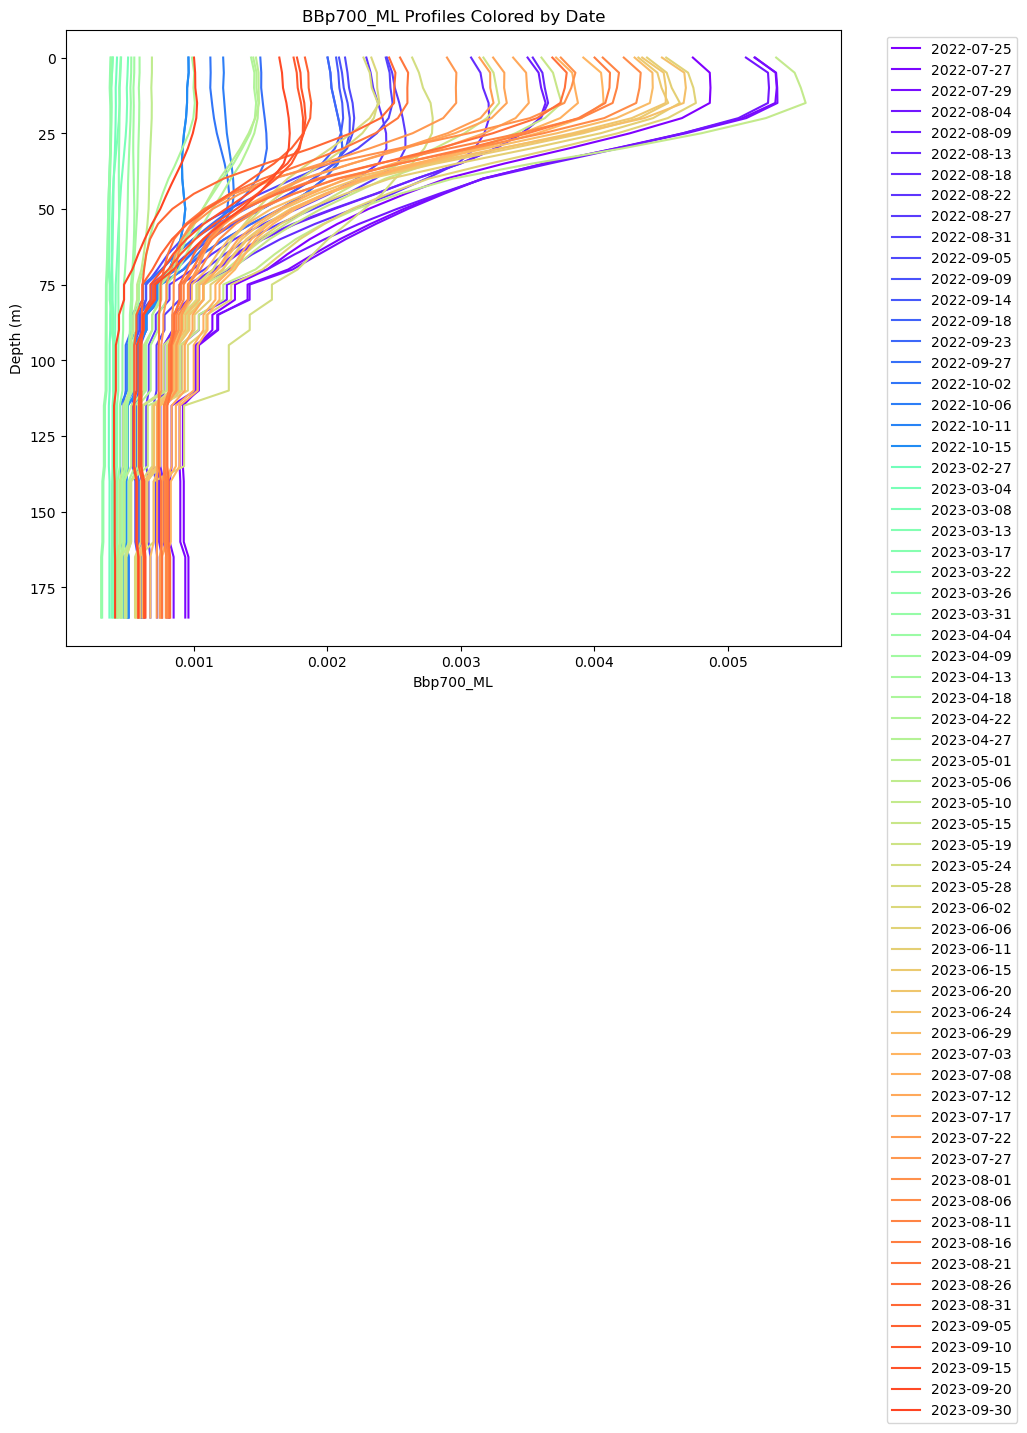

In [44]:
# Get unique dates and sort them
unique_dates = sorted(interpolated_df['date'].unique())

# Create a rainbow colormap
cmap = plt.get_cmap('rainbow')
norm = mcolors.Normalize(vmin=0, vmax=len(unique_dates)-1)

fig, ax = plt.subplots(figsize=(10, 8))

for i, date in enumerate(unique_dates):
    profile_data = interpolated_df[interpolated_df['date'] == date].dropna(subset=['BBP700_ML'])
    if not profile_data.empty:
        ax.plot(profile_data['BBP700_ML'], profile_data['PRES'], color=cmap(norm(i)), label=str(date.date()))

ax.set_xlabel('Bbp700_ML')
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()
ax.set_title('BBp700_ML Profiles Colored by Date')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [45]:
surface_par_df = interpolated_df[interpolated_df['PRES'] == 0][['date', 'PAR', 'latitude', 'longitude']].reset_index(drop=True)
surface_par_df

,date,PAR,latitude,longitude
0,2022-07-25 11:31:00,768.435242,58.067863,-23.156090
1,2022-07-27 11:21:00,723.483032,58.301963,-23.091653
2,2022-07-29 11:20:00,743.582642,58.414070,-22.903952
3,2022-08-04 11:21:00,654.714172,58.754253,-21.906957
4,2022-08-09 00:46:00,688.309631,59.121128,-22.562903
...,...,...,...,...
99,2023-11-17 18:12:00,NaN,63.184013,-39.971947
100,2023-11-27 02:38:00,NaN,63.123148,-40.127482
101,2023-12-06 19:34:00,NaN,62.246962,-41.197898
102,2023-12-16 03:08:00,NaN,62.302033,-40.592777


In [46]:
surface_par_df['latitude'][0], surface_par_df['longitude'][0]

(np.float64(58.067863333333335), np.float64(-23.15609))

In [47]:
import pvlib


tz = 'UTC'
daily_par = []

for i in range(len(surface_par_df)):
    
    lat, lon = surface_par_df['latitude'][i], surface_par_df['longitude'][i]
    location = pvlib.location.Location(lat, lon, tz)

    # Full day at 1-min resolution
    date = surface_par_df['date'][i].strftime('%Y-%m-%d')
    times = pd.date_range(
        f'{date} 00:00',
        f'{date} 23:59',
        freq='1min',
        tz=tz
    )

    clearsky = location.get_clearsky(times)
    ghi = clearsky['ghi']  # W m-2
    PAR_clear = ghi *4.57 # Convert to µmol photons m-2 s-1

    t_meas = pd.Timestamp(f'{date} 12:00', tz=tz)
    PAR_meas = surface_par_df['PAR'][i]  # example

    PAR_clear_meas = PAR_clear.loc[t_meas]

    scale = PAR_meas / PAR_clear_meas
    PAR_scaled = PAR_clear * scale

    # Convert µmol m-2 s-1 → mol m-2 day-1
    DLI = PAR_scaled.sum() * 60 / 1e6
    daily_par.append(DLI)

In [48]:
surface_par_df['daily_par'] = daily_par

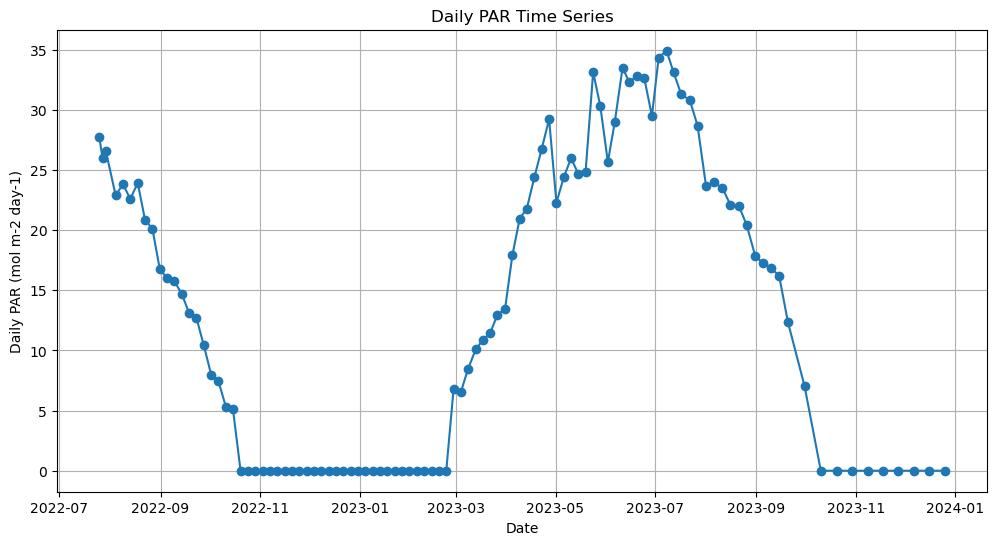

In [49]:
import matplotlib.pyplot as plt

# Plot the daily PAR time series
plt.figure(figsize=(12, 6))
plt.plot(surface_par_df['date'], surface_par_df['daily_par'], marker='o', linestyle='-')
plt.title('Daily PAR Time Series')
plt.xlabel('Date')
plt.ylabel('Daily PAR (mol m-2 day-1)')
plt.grid(True)
plt.show()

In [50]:
interpolated_df = interpolated_df.merge(surface_par_df[['date', 'daily_par']], on='date', how='left')

## Run CbPM

In [51]:
interpolated_df

,profile_id,date,PRES,latitude,longitude,BBP700,CHLA_ADJUSTED,CHLA_ML,BBP700_ML,PAR,temperature,salinity,daily_par
0,1,2022-07-25 11:31:00,0,58.067863,-23.156090,0.004476,1.1664,1.340331,0.004737,768.435242,12.6905,35.115299,27.704621
1,1,2022-07-25 11:31:00,1,58.067863,-23.156090,0.004349,1.1664,1.341171,0.004762,680.402161,12.6902,35.118040,27.704621
2,1,2022-07-25 11:31:00,2,58.067863,-23.156090,0.004223,1.1664,1.342010,0.004788,592.369080,12.6899,35.120780,27.704621
3,1,2022-07-25 11:31:00,3,58.067863,-23.156090,0.004096,1.1664,1.342850,0.004813,504.335999,12.6896,35.123521,27.704621
4,1,2022-07-25 11:31:00,4,58.067863,-23.156090,0.003969,1.1664,1.343689,0.004838,416.302917,12.6893,35.126261,27.704621
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20795,104,2023-12-25 11:43:00,195,62.293430,-40.884065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
20796,104,2023-12-25 11:43:00,196,62.293430,-40.884065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
20797,104,2023-12-25 11:43:00,197,62.293430,-40.884065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
20798,104,2023-12-25 11:43:00,198,62.293430,-40.884065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [52]:
interpolated_df['BBP470_ML'] = interpolated_df['BBP700_ML']/(470/400) 
interpolated_df['carbon_ML'] = 12128 * interpolated_df['BBP470_ML'] + 0.59

interpolated_df['BBP470_ADJUSTED'] = interpolated_df['BBP700']/(470/400) 
interpolated_df['carbon_ADJUSTED'] = 12128 * interpolated_df['BBP470_ADJUSTED'] + 0.59

In [53]:
def opp_befa(chl, irr, sst, dayL):
    if chl < 1.0:
        chl_tot = 38.0 * np.power(chl, 0.425)
    else:
        chl_tot = 40.2 * np.power(chl, 0.507)

    z_eu = 200.0 * np.power(chl_tot, (-0.293))

    if z_eu <= 102.0:
         z_eu = 568.2 * np.power(chl_tot, -0.746)

    if sst < -10.0:
        pb_opt = 0.0
    elif sst < -1.0:
        pb_opt = 1.13
    elif sst > 28.5:
        pb_opt = 4.0
    else:
        pb_opt = 1.2956 + 2.749e-1*sst + 6.17e-2*np.power(sst, 2) - \
            2.05e-2*np.power(sst, 3) + 2.462e-3*np.power(sst, 4) - \
            1.348e-4*np.power(sst, 5) + 3.4132e-6*np.power(sst, 6) - \
            3.27e-8*np.power(sst, 7)

    irrFunc = 0.66125 * irr / (irr + 4.1)

    npp = pb_opt * chl * dayL * irrFunc * z_eu

    return npp

def cal_dayL(lat, yDay):
    gamma = lat/180.0 * np.pi
    psi = yDay/365.0 * 2.0 * np.pi
    solarDec = (0.39637 - 22.9133*np.cos(psi) + 4.02543*np.sin(psi) - \
                0.38720*np.cos(2*psi) + 0.05200*np.sin(2*psi)) * np.pi/180.0
    r = -np.tan(gamma) * np.tan(solarDec)

    if r<=-1:
        return 24.0
    elif np.fabs(r)<1:
        return 24.0 * np.arccos(r) / np.pi
    else:
        return 0
    
def day_of_year(day, month, year=2024):
    return (datetime.date(year, month, day) - datetime.date(year, 1, 1)).days + 1

In [54]:
interpolated_df['year'] = interpolated_df['date'].dt.year
interpolated_df['month'] = interpolated_df['date'].dt.month
interpolated_df['day'] = interpolated_df['date'].dt.day

In [58]:
import datetime

dfs = []
depth_grid = np.arange(0,200)

# Iterate through each unique profile index
for i in interpolated_df['profile_id'].unique():
    # Filter for rows corresponding to the current 'JULD'
    temp_df = interpolated_df[interpolated_df['profile_id'] == i].copy()  # Use `.copy()` to avoid warnings

    # Extract the pressure and chlorophyll values for interpolation
    pres_values = temp_df['PRES'].to_numpy()
    chl_values = temp_df['CHLA_ADJUSTED'].to_numpy()
    carbon_values = temp_df['carbon_ADJUSTED'].to_numpy()
    temp_values = temp_df['temperature'].to_numpy()

    #extract ML derived variables
    chl_ML_values = temp_df['CHLA_ML'].to_numpy()
    carbon_ML_values = temp_df['carbon_ML'].to_numpy()

    # # Apply the running mean smoothing
    # chl_smoothed = running_mean(chl_values, window_size=5)
    # carbon_smoothed = running_mean(carbon_values, window_size=5)

    # Check for valid data before interpolation (avoid NaN values)
    mask = ~np.isnan(pres_values) & ~np.isnan(chl_values)
    pres_values = pres_values[mask]
    chl_values = chl_values[mask]
    carbon_values = carbon_values[mask]
    temp_values = temp_values[mask]

    chl_ML_values = chl_ML_values[mask]
    carbon_ML_values = carbon_ML_values[mask]

    # # Interpolate the CHLA_ADJUSTED onto the depth grid (0 to 199)
    # if len(pres_values) > 1:  # Ensure there's enough data to interpolate
    #     interpolator = interp1d(pres_values, chl_values, bounds_error=False, fill_value=np.nan)
    #     interpolated_chl = interpolator(depth_grid)
        
    #     interpolator = interp1d(pres_values, carbon_values, bounds_error=False, fill_value=np.nan)
    #     interpolated_carbon = interpolator(depth_grid)

    #     interpolator = interp1d(pres_values, temp_values, bounds_error=False, fill_value=np.nan)
    #     interpolated_temp = interpolator(depth_grid)
        
    # else:
    #     # If only one point or no valid data, fill with NaN
    #     print(temp_df['profile_index'].unique())
    #     interpolated_chl = np.full(depth_grid.shape, np.nan)
    #     interpolated_carbon = np.full(depth_grid.shape, np.nan)

    # Now we can extract other values and apply the cbpm_argo function
    # chl_z = interpolated_chl
    # Cphyto_z = interpolated_carbon
    irr = temp_df['daily_par'].mean()  # Mean irradiance value
    year = int(temp_df['year'].mean())
    month = int(temp_df['month'].mean())
    day = int(temp_df['day'].mean())
    lat = temp_df['latitude'].mean()
    sst = temp_values[0:5].mean()


    #calculation of daylength
    doy = day_of_year(day, month)
    day_length = cal_dayL(lat, doy)

    # Call the cbpm_argo function with interpolated data
    [pp_z, mu_z, par_z, prcnt_z, nutTempFunc_z, IgFunc_z, mzeu] = cbpm_argo.cbpm_argo(chl_values, carbon_values, irr, year, month, day, lat)

    #VGPM computation
    npp_vgpm = opp_befa(chl_values[0], irr, sst, day_length)

    size_max = len(temp_df)

    # Use .loc to explicitly assign new columns (expand results back into DataFrame)
    temp_df.loc[:, 'pp'] = pp_z[0:size_max]
    temp_df.loc[:, 'mu'] = mu_z[0:size_max]
    temp_df.loc[:, 'prcnt'] = prcnt_z[0:size_max]
    temp_df.loc[:, 'nutTempFunc'] = nutTempFunc_z[0:size_max]
    temp_df.loc[:, 'IgFunc'] = IgFunc_z[0:size_max]
    temp_df.loc[:, 'zeu'] = np.full(size_max, mzeu)
    temp_df.loc[:, 'npp_vgpm'] = np.full(size_max, npp_vgpm)

    # Call the cbpm_argo function with interpolated data from ML
    [pp_z, mu_z, par_z, prcnt_z, nutTempFunc_z, IgFunc_z, mzeu] = cbpm_argo.cbpm_argo(chl_ML_values, carbon_ML_values, irr, year, month, day, lat)

    #VGPM computation from ML
    npp_vgpm = opp_befa(chl_ML_values[0], irr, sst, day_length)

    temp_df.loc[:, 'pp_ML'] = pp_z[0:size_max]
    temp_df.loc[:, 'npp_vgpm_ML'] = np.full(size_max, npp_vgpm)

    # Append modified DataFrame to the list
    dfs.append(temp_df)


# Combine all DataFrames
final_df = pd.concat(dfs)

c:\Users\petit\Documents\Producitivity_estimates\Scripts\cbpm_py\cbpm_argo.py:139: RuntimeWarning: invalid value encountered in scalar divide
  prcnt_z[z] = par_z[z] / (irr * 0.975)
c:\Users\petit\Documents\Producitivity_estimates\Scripts\cbpm_py\cbpm_argo.py:139: RuntimeWarning: invalid value encountered in scalar divide
  prcnt_z[z] = par_z[z] / (irr * 0.975)
c:\Users\petit\Documents\Producitivity_estimates\Scripts\cbpm_py\cbpm_argo.py:139: RuntimeWarning: invalid value encountered in scalar divide
  prcnt_z[z] = par_z[z] / (irr * 0.975)
c:\Users\petit\Documents\Producitivity_estimates\Scripts\cbpm_py\cbpm_argo.py:139: RuntimeWarning: invalid value encountered in scalar divide
  prcnt_z[z] = par_z[z] / (irr * 0.975)
c:\Users\petit\Documents\Producitivity_estimates\Scripts\cbpm_py\cbpm_argo.py:139: RuntimeWarning: invalid value encountered in scalar divide
  prcnt_z[z] = par_z[z] / (irr * 0.975)
c:\Users\petit\Documents\Producitivity_estimates\Scripts\cbpm_py\cbpm_argo.py:139: Runtime

In [59]:
final_df

,profile_id,date,PRES,latitude,longitude,BBP700,CHLA_ADJUSTED,CHLA_ML,BBP700_ML,PAR,...,day,pp,mu,prcnt,nutTempFunc,IgFunc,zeu,npp_vgpm,pp_ML,npp_vgpm_ML
0,1,2022-07-25 11:31:00,0,58.067863,-23.156090,0.004476,1.1664,1.340331,0.004737,768.435242,...,25,93.545170,1.999413,1.006400,1.0,0.999707,40.0,1836.803631,98.937118,2002.608951
1,1,2022-07-25 11:31:00,1,58.067863,-23.156090,0.004349,1.1664,1.341171,0.004762,680.402161,...,25,90.841471,1.997397,0.822126,1.0,0.998699,40.0,1836.803631,99.353939,2002.608951
2,1,2022-07-25 11:31:00,2,58.067863,-23.156090,0.004223,1.1664,1.342010,0.004788,592.369080,...,25,88.000376,1.992152,0.685559,1.0,0.996076,40.0,1836.803631,99.588384,2002.608951
3,1,2022-07-25 11:31:00,3,58.067863,-23.156090,0.004096,1.1664,1.342850,0.004813,504.335999,...,25,84.951336,1.981737,0.581045,1.0,0.990868,40.0,1836.803631,99.520449,2002.608951
4,1,2022-07-25 11:31:00,4,58.067863,-23.156090,0.003969,1.1664,1.343689,0.004838,416.302917,...,25,81.645162,1.964479,0.498735,1.0,0.982239,40.0,1836.803631,99.042431,2002.608951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20795,104,2023-12-25 11:43:00,195,62.293430,-40.884065,NaN,NaN,NaN,NaN,NaN,...,25,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
20796,104,2023-12-25 11:43:00,196,62.293430,-40.884065,NaN,NaN,NaN,NaN,NaN,...,25,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
20797,104,2023-12-25 11:43:00,197,62.293430,-40.884065,NaN,NaN,NaN,NaN,NaN,...,25,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
20798,104,2023-12-25 11:43:00,198,62.293430,-40.884065,NaN,NaN,NaN,NaN,NaN,...,25,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN


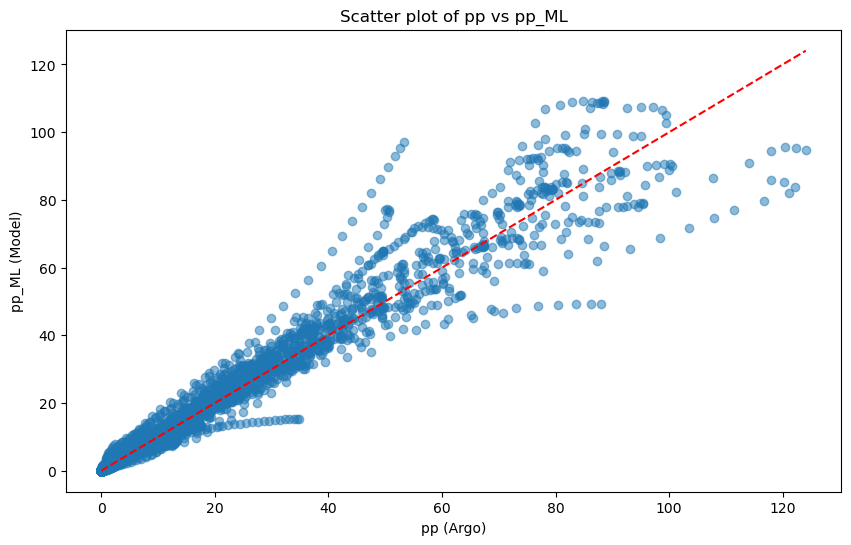

In [60]:
plt.figure(figsize=(10, 6))
plt.scatter(final_df['pp'], final_df['pp_ML'], alpha=0.5)
plt.plot([final_df['pp'].min(), final_df['pp'].max()], [final_df['pp'].min(), final_df['pp'].max()], 'r--')
plt.xlabel('pp (Argo)')
plt.ylabel('pp_ML (Model)')
plt.title('Scatter plot of pp vs pp_ML')
plt.show()

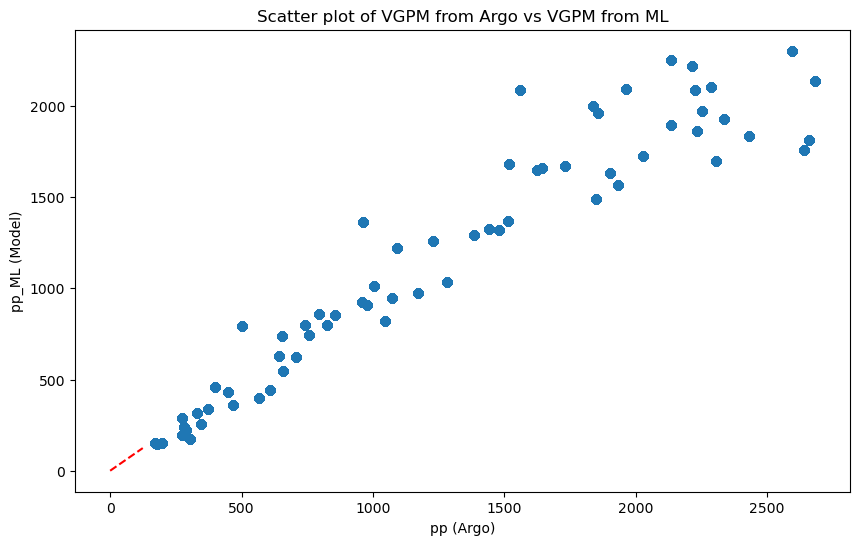

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(final_df['npp_vgpm'], final_df['npp_vgpm_ML'], alpha=0.5)
plt.plot([final_df['pp'].min(), final_df['pp'].max()], [final_df['pp'].min(), final_df['pp'].max()], 'r--')
plt.xlabel('pp (Argo)')
plt.ylabel('pp_ML (Model)')
plt.title('Scatter plot of VGPM from Argo vs VGPM from ML')
plt.show()

In [63]:
# Create a new dataframe with one row per profile_id
# Integrate pp and pp_ML over depth (sum, assuming 1m depth bins)
# Keep average of npp_vgpm and npp_vgpm_ML (which are constant per profile)

grouped = final_df.groupby('profile_id')

profile_summary_df = grouped.agg({
    'date': 'first',
    'latitude': 'first',
    'longitude': 'first',
    'pp': 'sum',
    'pp_ML': 'sum',
    'npp_vgpm': 'mean',
    'npp_vgpm_ML': 'mean'
})

profile_summary_df

,date,latitude,longitude,pp,pp_ML,npp_vgpm,npp_vgpm_ML
profile_id,,,,,,,
1,2022-07-25 11:31:00,58.067863,-23.156090,1549.598363,1673.383526,1836.803631,2002.608951
2,2022-07-27 11:21:00,58.301963,-23.091653,1520.669293,1688.925868,1962.402061,2095.571315
3,2022-07-29 11:20:00,58.414070,-22.903952,1582.726971,1731.121337,2287.026992,2102.718168
4,2022-08-04 11:21:00,58.754253,-21.906957,1576.202369,1652.840023,2134.416625,2255.244289
5,2022-08-09 00:46:00,59.121128,-22.562903,1536.228608,1383.513633,2028.862628,1726.477437
...,...,...,...,...,...,...,...
100,2023-11-17 18:12:00,63.184013,-39.971947,0.000000,0.000000,0.000000,NaN
101,2023-11-27 02:38:00,63.123148,-40.127482,0.000000,0.000000,0.000000,NaN
102,2023-12-06 19:34:00,62.246962,-41.197898,0.000000,0.000000,0.000000,NaN


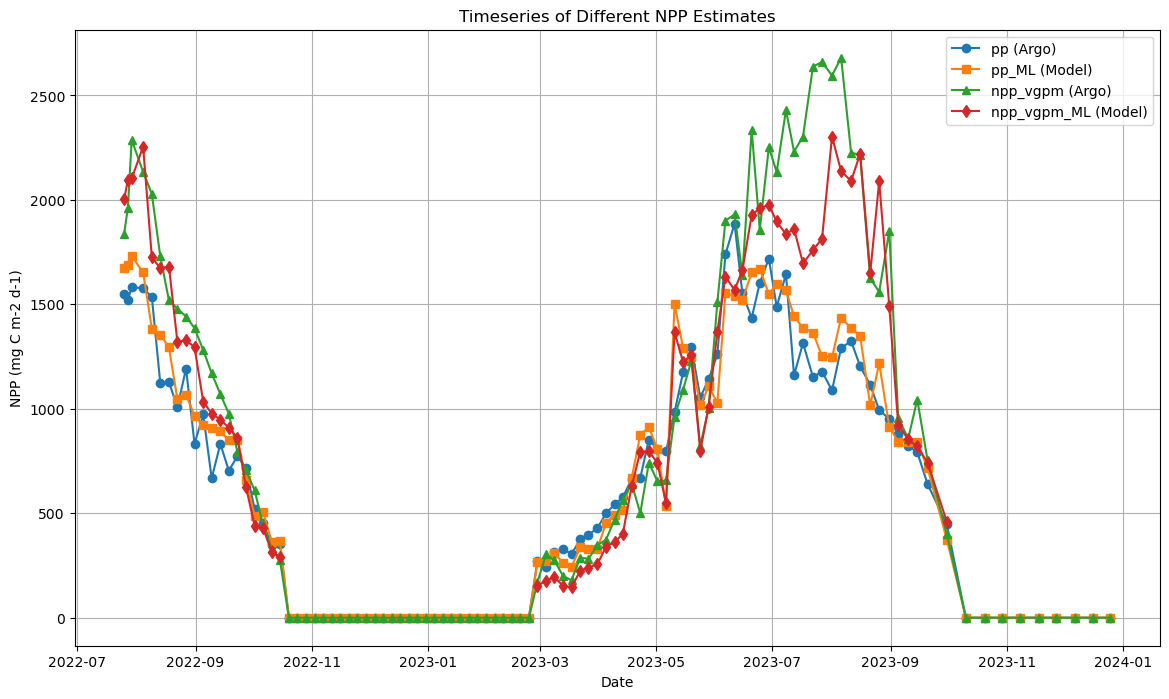

In [64]:
import matplotlib.pyplot as plt

# Plot the timeseries of different NPP estimates
plt.figure(figsize=(14, 8))

plt.plot(profile_summary_df['date'], profile_summary_df['pp'], label='pp (Argo)', marker='o')
plt.plot(profile_summary_df['date'], profile_summary_df['pp_ML'], label='pp_ML (Model)', marker='s')
plt.plot(profile_summary_df['date'], profile_summary_df['npp_vgpm'], label='npp_vgpm (Argo)', marker='^')
plt.plot(profile_summary_df['date'], profile_summary_df['npp_vgpm_ML'], label='npp_vgpm_ML (Model)', marker='d')

plt.xlabel('Date')
plt.ylabel('NPP (mg C m-2 d-1)')
plt.title('Timeseries of Different NPP Estimates')
plt.legend()
plt.grid(True)
plt.show()

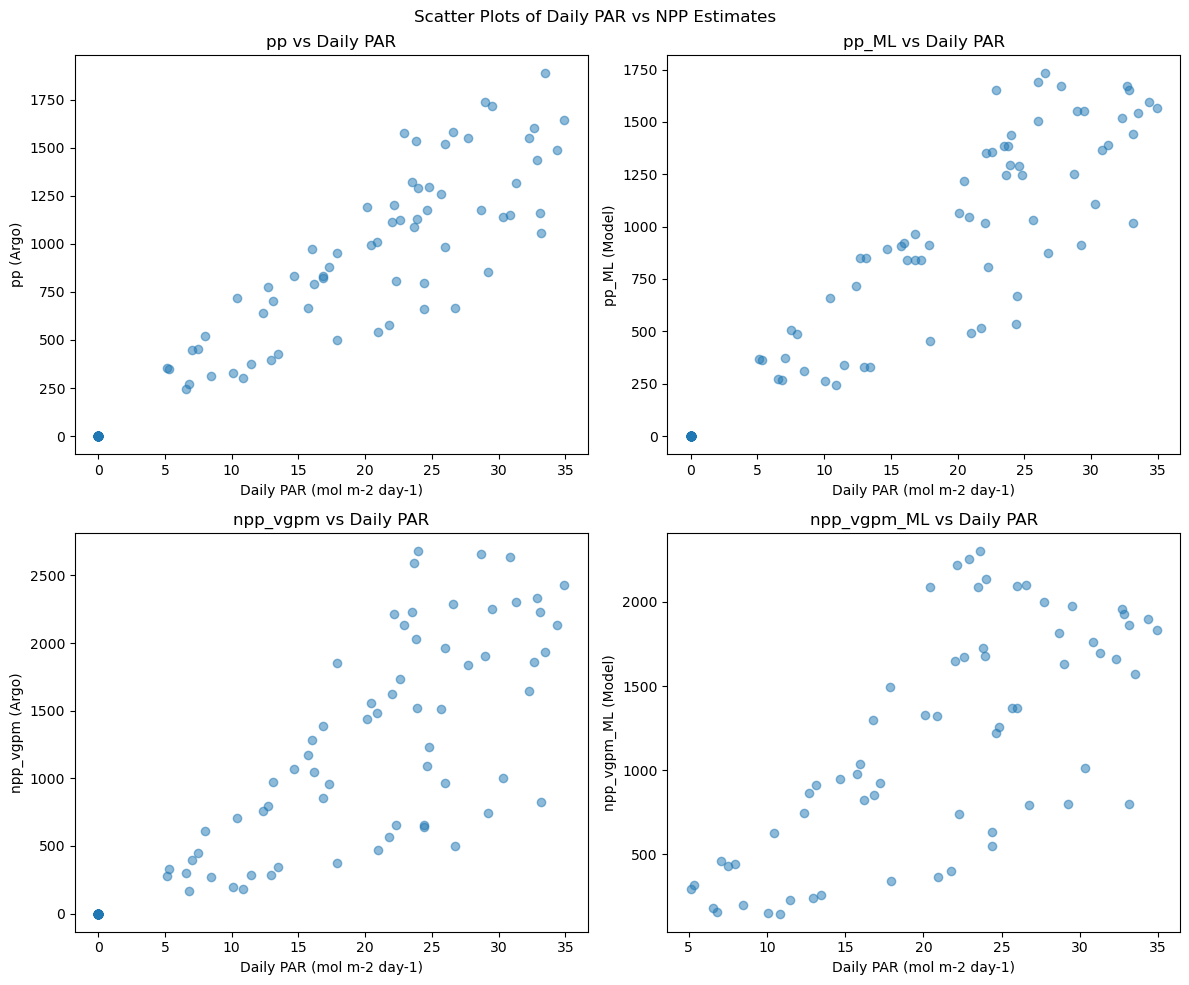

In [65]:
import matplotlib.pyplot as plt

# Merge profile_summary_df with surface_par_df on 'date' to get daily_par
merged_df = profile_summary_df.merge(surface_par_df[['date', 'daily_par']], on='date', how='left')

# Create scatter plots for each pp estimate against daily_par
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Scatter Plots of Daily PAR vs NPP Estimates')

# pp vs daily_par
axes[0, 0].scatter(merged_df['daily_par'], merged_df['pp'], alpha=0.5)
axes[0, 0].set_xlabel('Daily PAR (mol m-2 day-1)')
axes[0, 0].set_ylabel('pp (Argo)')
axes[0, 0].set_title('pp vs Daily PAR')

# pp_ML vs daily_par
axes[0, 1].scatter(merged_df['daily_par'], merged_df['pp_ML'], alpha=0.5)
axes[0, 1].set_xlabel('Daily PAR (mol m-2 day-1)')
axes[0, 1].set_ylabel('pp_ML (Model)')
axes[0, 1].set_title('pp_ML vs Daily PAR')

# npp_vgpm vs daily_par
axes[1, 0].scatter(merged_df['daily_par'], merged_df['npp_vgpm'], alpha=0.5)
axes[1, 0].set_xlabel('Daily PAR (mol m-2 day-1)')
axes[1, 0].set_ylabel('npp_vgpm (Argo)')
axes[1, 0].set_title('npp_vgpm vs Daily PAR')

# npp_vgpm_ML vs daily_par
axes[1, 1].scatter(merged_df['daily_par'], merged_df['npp_vgpm_ML'], alpha=0.5)
axes[1, 1].set_xlabel('Daily PAR (mol m-2 day-1)')
axes[1, 1].set_ylabel('npp_vgpm_ML (Model)')
axes[1, 1].set_title('npp_vgpm_ML vs Daily PAR')

plt.tight_layout()
plt.show()